In [126]:
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

# read data

In [127]:
words = open('../data/names.txt', 'r').read().splitlines()

In [128]:
len(words)

32033

In [129]:
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [130]:
chars = sorted(list(set(''.join(words))))

# util

In [131]:
itos = {}
itos[0] = '.'
itos |= {i+1: s for i, s in enumerate(chars)}

In [132]:
stoi = {s: i for i, s in itos.items()}

# Build a neural language model

## prepare data

In [133]:
def build_dataset(data):
    block_size = 3
    X, Y = [], []
    for w in data[:]:
        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            # print(''.join([itos[i] for i in context]), '--->', itos[ix])
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]        

    X = torch.tensor(X)
    Y = torch.tensor(Y)        
    print(X.shape, Y.shape)
    return X, Y

In [134]:
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
         
Xtr, Ytr = build_dataset(words[:n1])
Xdv, Ydv = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])                               

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


# Train a neural language model

In [135]:
C = torch.randn(len(itos), 10)
w1 = torch.randn(30, 200)
b1 = torch.randn(200)
w2 = torch.randn(200, len(itos))
b2 = torch.randn(len(itos))
parameters = [C, w1, b1, w2, b2]

In [136]:
sum(p.nelement() for p in parameters)

11897

In [137]:
for p in parameters:
    p.requires_grad = True

In [138]:
loglossi = []
lossi = []
STEPS = 200_000
for i in tqdm(range(STEPS)):
    # mini-batch
    ix = torch.randint(0, Xtr.shape[0], (32,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    # forward
    emb = C[Xb] # (32, 3, 2)
    h = (emb.view(emb.shape[0], -1) @ w1 + b1).tanh() # (32, 100)
    logits = h @ w2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Yb)

    # backward
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < STEPS//2 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # tracking
    loglossi.append(loss.log10().item())
    lossi.append(loss.item())

100%|████████████████████████████████████████████████████████████████████████████████████| 200000/200000 [01:13<00:00, 2710.55it/s]


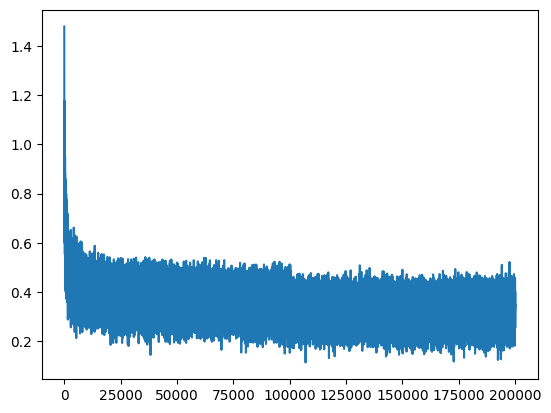

In [139]:
plt.plot(loglossi)

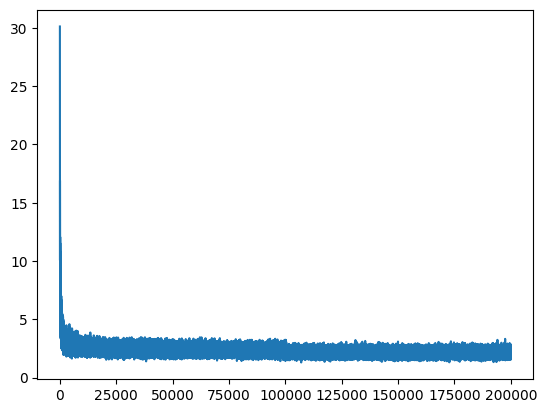

In [140]:
plt.plot(lossi)

## compute loss on train/dev/test

In [141]:
def eval_dataset(X, Y):
    with torch.no_grad():
        emb = C[X] # (32, 3, 2)
        h = (emb.view(emb.shape[0], -1) @ w1 + b1).tanh() # (32, 100)
        logits = h @ w2 + b2 # (32, 27)
        loss = F.cross_entropy(logits, Y)
        print(loss.item())

In [142]:
eval_dataset(Xtr, Ytr)
eval_dataset(Xdv, Ydv)
# eval_dataset(Xte, Yte)

2.125647783279419
2.1720478534698486


## visualize the embedding

In [143]:
from sklearn.manifold import TSNE

In [144]:
tsne = TSNE(n_components=2, verbose=1, random_state=123, perplexity=5)
# tsne = TSNE(n_components=2, verbose=1, random_state=123)

In [145]:
z = tsne.fit_transform(C.detach().numpy())

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 27 samples in 0.000s...
[t-SNE] Computed neighbors for 27 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 27 / 27
[t-SNE] Mean sigma: 0.648344
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.272018
[t-SNE] KL divergence after 1000 iterations: 0.285166


In [146]:
C.shape, z.shape

(torch.Size([27, 10]), (27, 2))

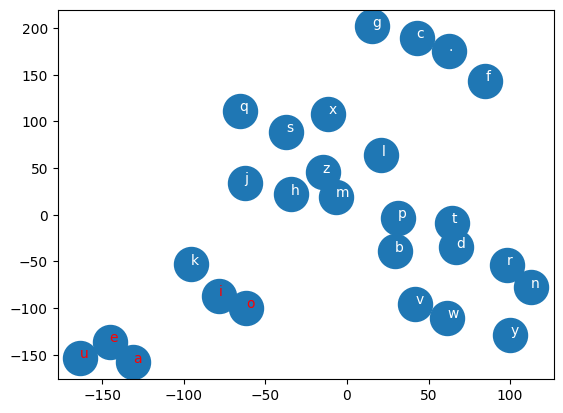

In [147]:
plt.scatter(z[:,0].data, z[:,1].data, s=600)
for i in range(z.shape[0]):
    if itos[i] in 'aeiou':
        c = 'red'
    else:
        c = 'white'
    plt.text(z[i,0].item(), z[i,1].item(), itos[i], color=c)

# generate names

In [169]:
g = torch.Generator().manual_seed(2147483647 + 10)

In [170]:
block_size = 3
for _ in range(10):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = (emb.view(1, -1) @ w1 + b1).tanh()
        logits = h @ w2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

carpa.
fati.
hari.
kimricheviyah.
cassie.
mahnen.
delyah.
jarqui.
nellara.
chaiir.
